In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import seaborn as sns

import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora
import re
import spacy

from bs4 import BeautifulSoup
from wordcloud import WordCloud

import phik

import warnings
warnings.filterwarnings("ignore")
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from gensim.models import CoherenceModel

def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

C:\Users\svawe\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
##Change path to data
df = pd.read_csv(r"C:\Users\svawe\twsm_project_corpus2.csv", index_col= 0)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str] #turns the strings into a list of strings 
df["accept"] = rejoined #before accept was a string of a list;  must have happened due to formatting

df.shape

(2283, 3)

In [3]:
#clean typical words we found during labelling
##this must be due to the way the texts were extracted and should not be included in training
import re

df["clean_text"] = df["text"].apply(pre_process)
new_text = [re.sub("start_cite|end_cite|cite_\w+", "", text) for text in df["clean_text"]]
df["new_text"] = new_text
df["clean_text"] = df["new_text"].apply(pre_process)

In [4]:
#further text cleaning for special characters etc.
new_text = [re.sub('\s(?=[\.,:;])', '', text) for text in df["clean_text"]]
df["new_text"] = new_text
df["new_text"][3]

'this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.'

# Exploratory data analysis

on average each text has 1.258 labels; 78.3180026281209% of labels have only one label


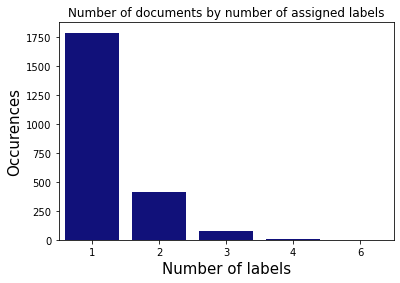

In [5]:
#Since this is a multi label problem, we are interested in the amount of labels per document
df["labels_num"] = [len(labels) for labels in df.accept]
#Lets also compute the average labels per text
avg_labels_per_text = round(np.mean([len(labels) for labels in df.accept]),3)
print(f"on average each text has {avg_labels_per_text} labels; {df[df.labels_num == 1].shape[0] / df.shape[0] * 100}% of labels have only one label")
sns.countplot("labels_num", data = df, color = "darkblue")
plt.xlabel("Number of labels", fontsize = 15)
plt.ylabel("Occurences", fontsize = 15)
plt.title("Number of documents by number of assigned labels");

In [6]:
#For further EDA we create a new data frame which only has one label; this will help us analyse the words / topics per label
df_new = df.explode("accept")[["new_text", "accept"]]

#further preprocessing for LDA later
data_stripped = []
for i in df_new.new_text: 
    text = i.lower() #remove upper case letters to allow grouping
    text = remove_stopwords(text)
    text = strip_punctuation(text) #remove all instances of . and : 
    text = strip_tags(text)
    text = strip_multiple_whitespaces(text) #remove dupplicate spaces
    text = strip_short(text) #short removes also potentially relevant words such as "et" "al" 
    data_stripped.append(text)

df_new["lda_text"] = data_stripped

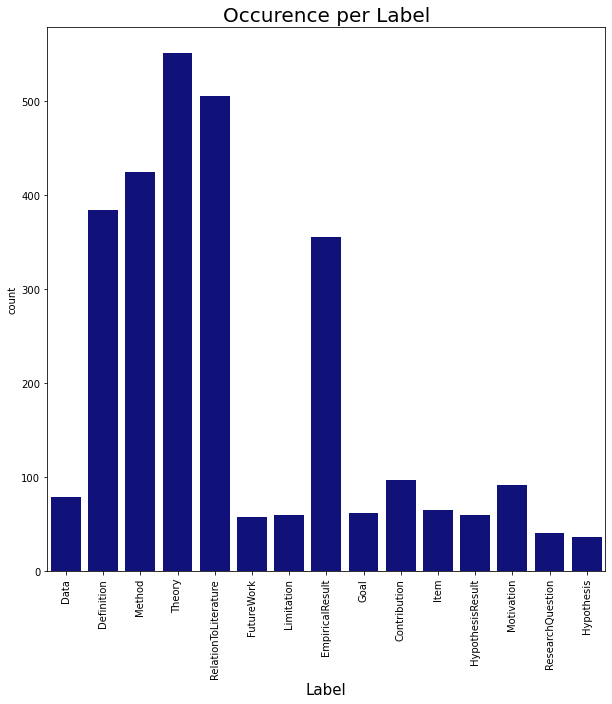

In [7]:
#How common is every label? 
##This is on the exploded dataframe, so occurence may be in single-label or multi-label documents
fig = plt.figure(figsize = (10,10))
counts = sns.countplot(x = df_new.accept, color = "darkblue")
counts.set_xticklabels(labels = df_new.accept.unique(), rotation = 90)
plt.xlabel("Label", fontsize = 15)
plt.title("Occurence per Label", fontsize = 20);
#we can see that 5 labels dominate the whole dataframe; this is a heavy argument to use stratified KFold CV later

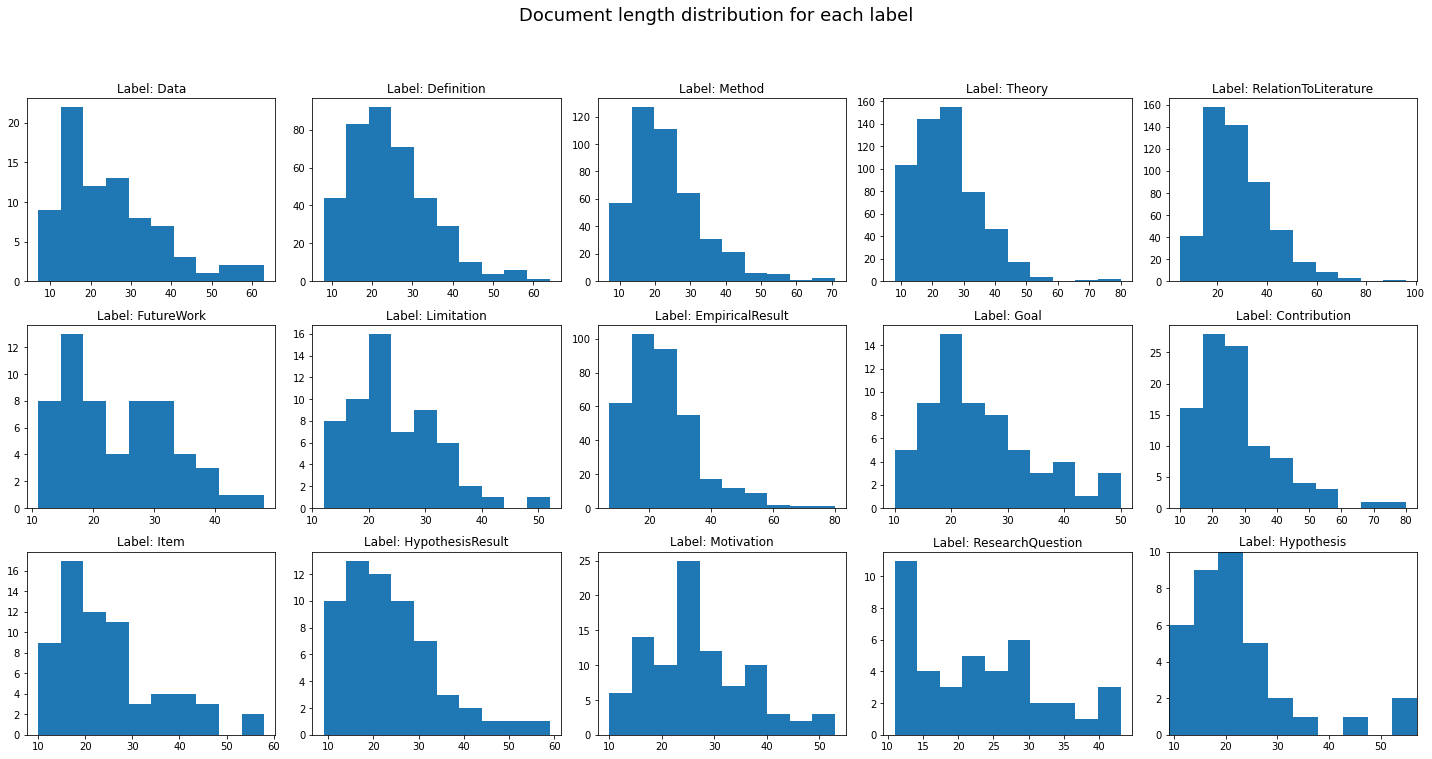

In [8]:
#Lets see how many words we have per label
doc_len = [len(row.split(" ")) for row in df_new.new_text]
df_new["doc_len"] = doc_len

#Number of words per Label
fig, axes = plt.subplots(3, 5, figsize=(20,10))

for i, ax in enumerate(axes.flatten()):
    label = df_new.accept.unique()[i]
    fig.add_subplot(ax)
    ax.hist(df_new[df_new.accept == label].doc_len)
    ax.set_title(f'Label: {label}', fontdict=dict(size=12))


plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Document length distribution for each label", 
             y=1.05,
             fontsize=18,
             )
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#Very similar along all labels, the max length for our sentence BERT should be around 75

Text(0.5, 1.0, 'Document length distribution by Label')

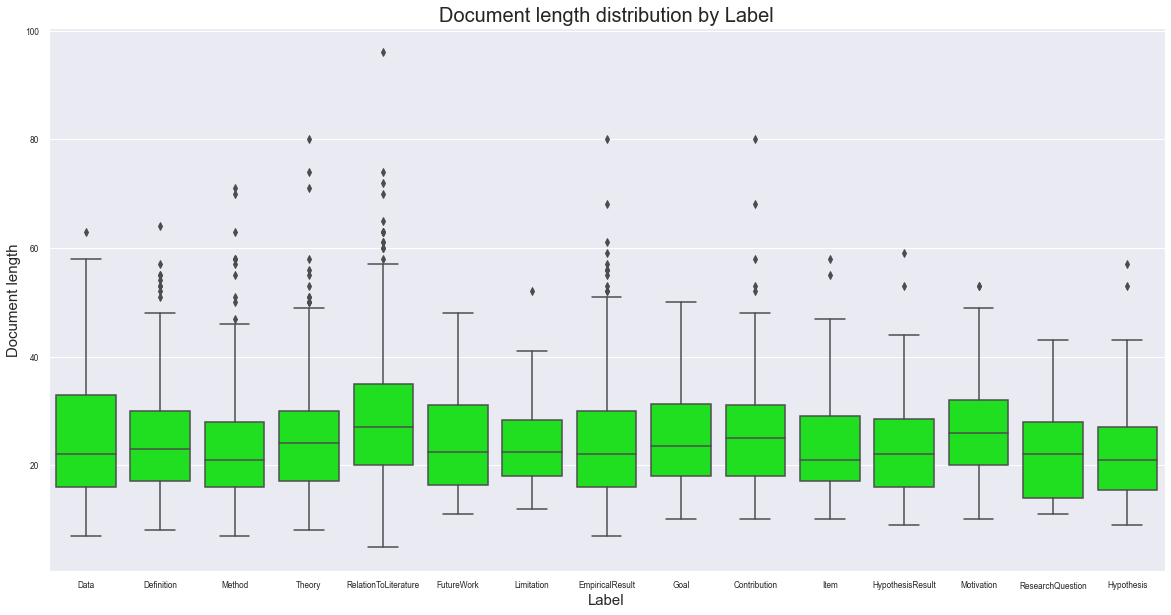

In [9]:
#Number of words per Label
sns.set(font_scale = 0.75)
plt.figure(figsize = (20,10))
sns.boxplot(x = "accept", y = "doc_len", data = df_new, color = "lime")
plt.xlabel("Label", fontsize = 15)
plt.ylabel("Document length", fontsize = 15)
plt.title("Document length distribution by Label", fontsize = 20)

<AxesSubplot:xlabel='text_to_explode'>

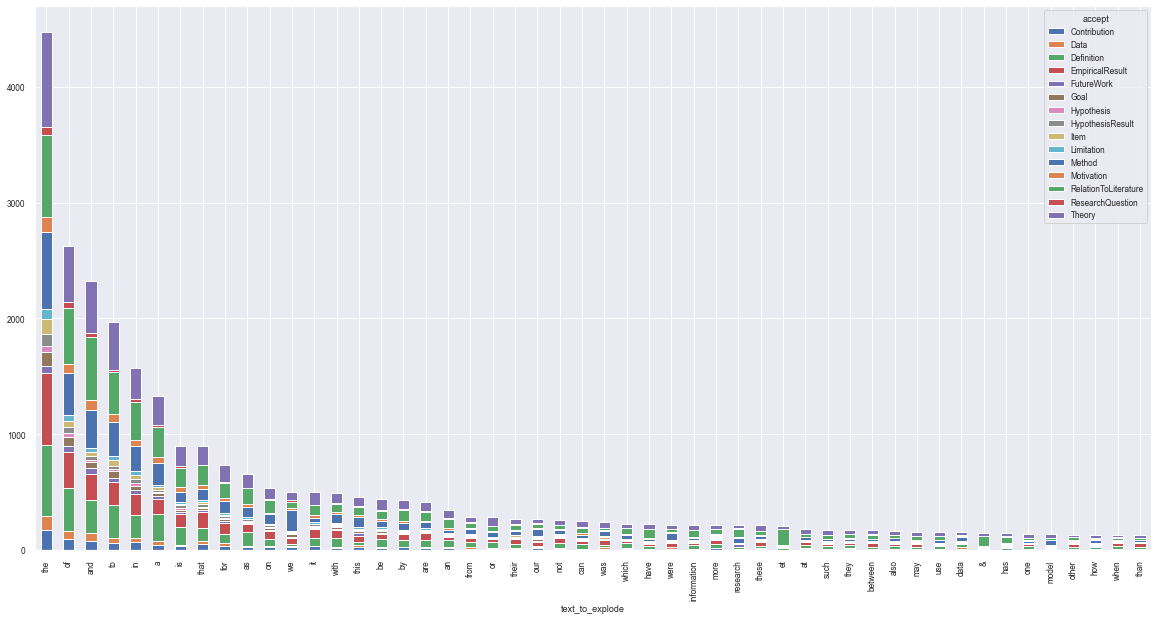

In [10]:
#Most common words and the labels they are distributed to
text_to_explode = [text.split(" ") for text in df_new.new_text]
df_new["text_to_explode"] = text_to_explode
text_exploded = df_new.explode("text_to_explode")

#Words and wordcounts in the data
series = df_new.new_text.str.split(expand=True).stack().value_counts().reset_index()
series.columns = ["word", "count"]

#take only the 50 most common words
df_zipf = text_exploded[text_exploded.text_to_explode.isin(series.word.iloc[:50].tolist())]
sorter = series.word.iloc[:50].tolist()
pd.crosstab(df_zipf["text_to_explode"], df_zipf["accept"]).reindex(sorter).plot(kind = "bar", stacked = True, figsize = (20,10))
#to interpret the colours, you must not simply look at individual bar size, but at relational bar size, since our labels are unbalanced!
#we can see that there are uneven distributions for certain words such as "have", "we", "et" or "&"
#these will probably help fitting the sentence ber
#however, those are stopwords or short words that are going to be dropped for the LDA

<AxesSubplot:xlabel='text_to_explode'>

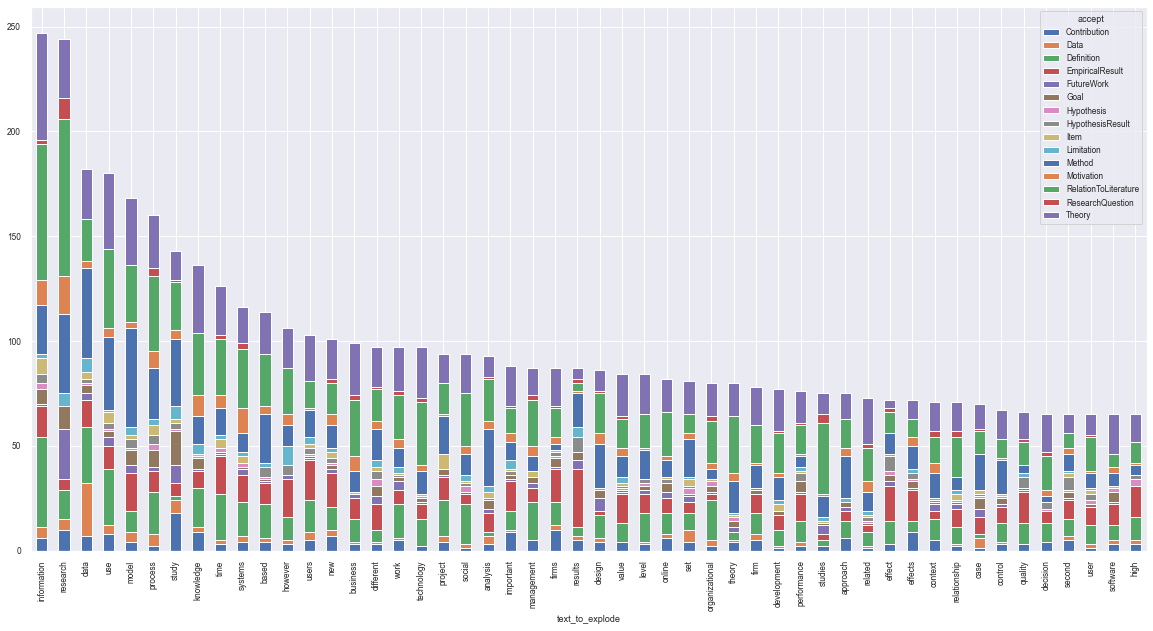

In [11]:
#Most common filtered words and the label they are distributed to
text_to_explode = [text.split(" ") for text in df_new.lda_text]
df_new["text_to_explode"] = text_to_explode
text_exploded = df_new.explode("text_to_explode")

#Words and wordcounts in the data
series = df_new.lda_text.str.split(expand=True).stack().value_counts().reset_index()
series.columns = ["word", "count"]

#take only the 50 most common words
df_zipf = text_exploded[text_exploded.text_to_explode.isin(series.word.iloc[:50].tolist())]
sorter = series.word.iloc[:50].tolist()
pd.crosstab(df_zipf["text_to_explode"], df_zipf["accept"]).reindex(sorter).plot(kind = "bar", stacked = True, figsize = (20,10))
#to interpret the colours, you must not simply look at individual bar size, but at relational bar size, since our labels are unbalanced!
#certain words, for example "research" and "studies" seem to be havy indicators for relation to literature and future work
#while the word "study" is a bigger indicator for Contribution, Future Work and Method and less for relation to literature
#"analysis", "based", "design" are indicators for method

## Label Correlation 

In [12]:
#One Hot Encode the Columns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe_tr = ohe.fit_transform(np.array(df_new.accept).reshape(-1,1))
ohe_tr_full = [list(sparse) for sparse in ohe_tr]

labels = list(df_new.accept.unique())
labels.sort()
for index, label in enumerate(labels):
    df_new[f"{label}"] = ohe_tr.toarray().T[index]

corr = df_new[labels]
#At this point the dataframe is still exploded, which will not work for correlation, hence we need to recombine it

#create empty dataframe to overwrite rows in
corr_new = pd.DataFrame(0, index = np.arange(df.shape[0]), columns = corr.columns)

#remerge exploded rows by adding columns with same index together
for index in corr.index:
    if corr.loc[index].shape == (15,): corr_new.loc[index] = corr.loc[index] #these are one single label and can be appended as is
    else: corr_new.loc[index] = np.sum(corr.loc[index], axis = 0) #these are multi label and need to be summed up

#drop all rows that were not overwritten after remerge
idxs = []
for index, sum in enumerate(list(corr_new.sum(axis = 1))):
    if sum == 0: idxs.append(index)
corr_new = corr_new.drop(index = idxs)

#worked like a charm 
corr_new

,Contribution,Data,Definition,EmpiricalResult,FutureWork,Goal,Hypothesis,HypothesisResult,Item,Limitation,Method,Motivation,RelationToLiterature,ResearchQuestion,Theory
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


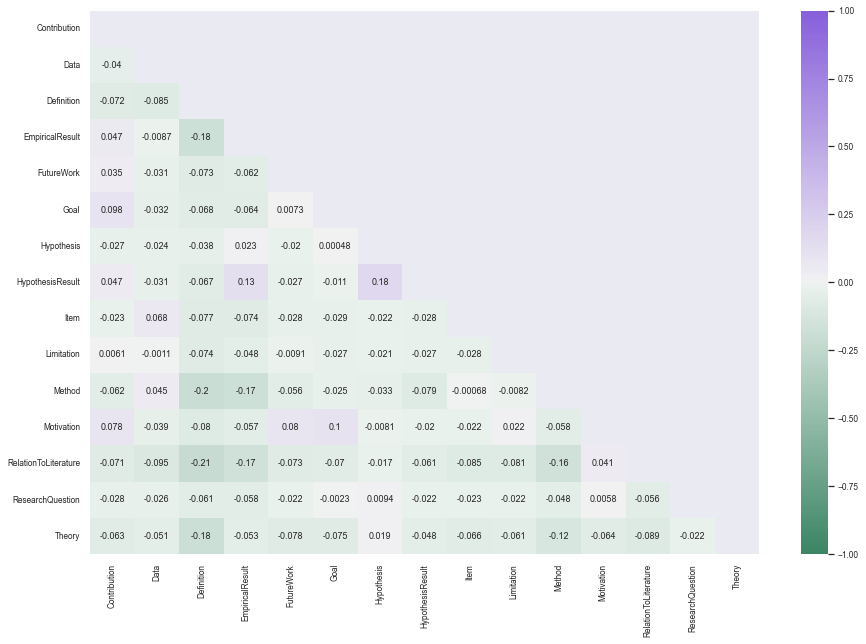

In [13]:
fig = plt.figure(figsize = (15,10))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
mask = np.triu(np.ones_like(corr_new.corr(), dtype=np.bool))
sns.heatmap(corr_new.corr(), annot = True, mask = mask, vmin=-1, vmax=1, cmap = cmap);
#the correlation is rather an inccaturate measure for two binary variables; so lets use phi-k instead

interval columns not set, guessing: ['Contribution', 'Data', 'Definition', 'EmpiricalResult', 'FutureWork', 'Goal', 'Hypothesis', 'HypothesisResult', 'Item', 'Limitation', 'Method', 'Motivation', 'RelationToLiterature', 'ResearchQuestion', 'Theory']


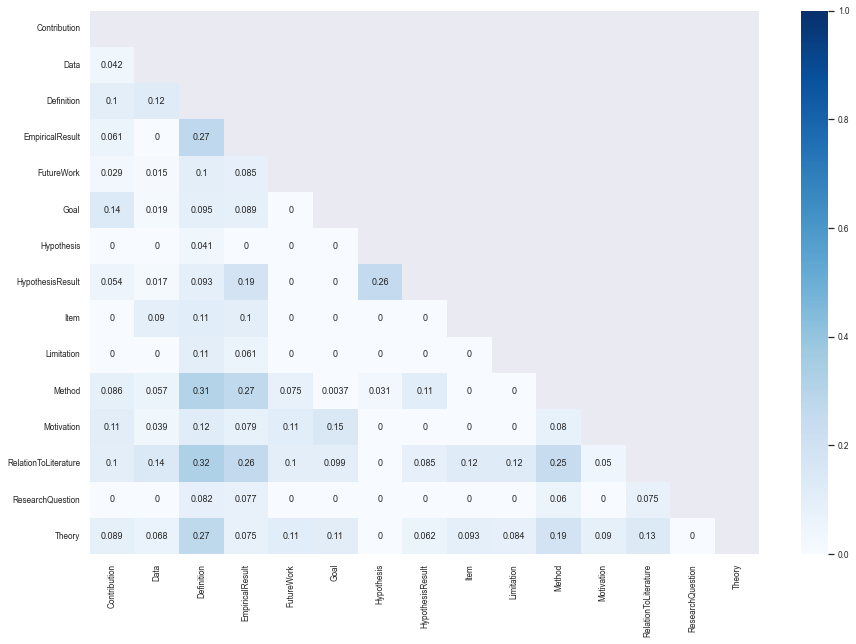

In [14]:
#Phi-K Matrix
phi = corr_new.phik_matrix()
fig = plt.figure(figsize = (15,10))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
mask = np.triu(np.ones_like(corr_new.corr(), dtype=np.bool))
sns.heatmap(phi, annot = True, mask = mask, vmin=0, vmax=1, cmap = "Blues");
#ER 4 correlations >= 0.15, HR 2 correlations >= 0.15, Method 4 correlations > 0.15
#RTL 3 correlations >= 0.15, Theory 2 correlations >= 0.15, Definition 4 correlations > 0.25
#Hypothesis 1 correlation >= 0.25

# -> 7 out of 15 labels have correlation with other labels 

# Topic Modeling

## LDA with gensim

In [15]:
#create necessary tokens, dict and matrix for LDA
tokens = [[word for word in text.split()] for text in df_new.lda_text]
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_above=0.1)
doc_term_matrix = [dictionary.doc2bow(patent) for patent in tokens]

In [16]:
LDA = gensim.models.LdaMulticore
ldamodel = LDA(corpus = doc_term_matrix,
                id2word = dictionary,
                num_topics = df_new.accept.nunique(), # = 15
                random_state = 0,
                chunksize = 5000,
                passes = 50, 
                workers = 56, #number of cores on zeno
                iterations = 50) 

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis #many of the clusters seem to be close to another

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.001655 -0.119499       1        1  7.896760
13     0.042510 -0.063274       2        1  7.586119
8     -0.098747 -0.050150       3        1  7.321936
3     -0.059451 -0.084198       4        1  7.227033
4      0.037033 -0.040735       5        1  7.212478
9     -0.022193  0.159680       6        1  6.964570
14     0.018305  0.026544       7        1  6.616406
0     -0.093942 -0.089803       8        1  6.531826
7     -0.027580 -0.078374       9        1  6.499556
12     0.148421 -0.019982      10        1  6.389829
2     -0.185575  0.114700      11        1  6.294268
6      0.042800  0.172520      12        1  6.185883
1     -0.011982  0.029630      13        1  5.871128
5      0.036220  0.027397      14        1  5.853601
10     0.175836  0.015542      15        1  5.548606, topic_info=              Term        Freq       Total Category  logprob  loglift
242        project   90.000000   90.000000  Default  30.0000  30.0000
391    information  233.000000  233.000000  Default  29.0000  29.0000
138          model  158.000000  158.000000  Default  28.0000  28.0000
386            use  169.000000  169.000000  Default  27.0000  27.0000
241        process  151.000000  151.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
488  communication    9.777415   48.161055  Topic15  -5.1080   1.2971
69       knowledge   11.342172  128.867013  Topic15  -4.9595   0.4614
53            risk    9.613678   60.346200  Topic15  -5.1249   1.0547
41            firm    9.143618   74.435441  Topic15  -5.1750   0.7947
126        results    9.191598   82.824782  Topic15  -5.1697   0.6932

[937 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
645       7  0.902773    000
1028      1  0.303648    100
1028     10  0.607296    100
1290      1  0.152157   1979
1290      8  0.152157   1979
...     ...       ...    ...
686       3  0.055599  years
686       5  0.111198  years
686       8  0.222396  years
686      11  0.500390  years
686      13  0.055599  years

[2970 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 9, 4, 5, 10, 15, 1, 8, 13, 3, 7, 2, 6, 11])

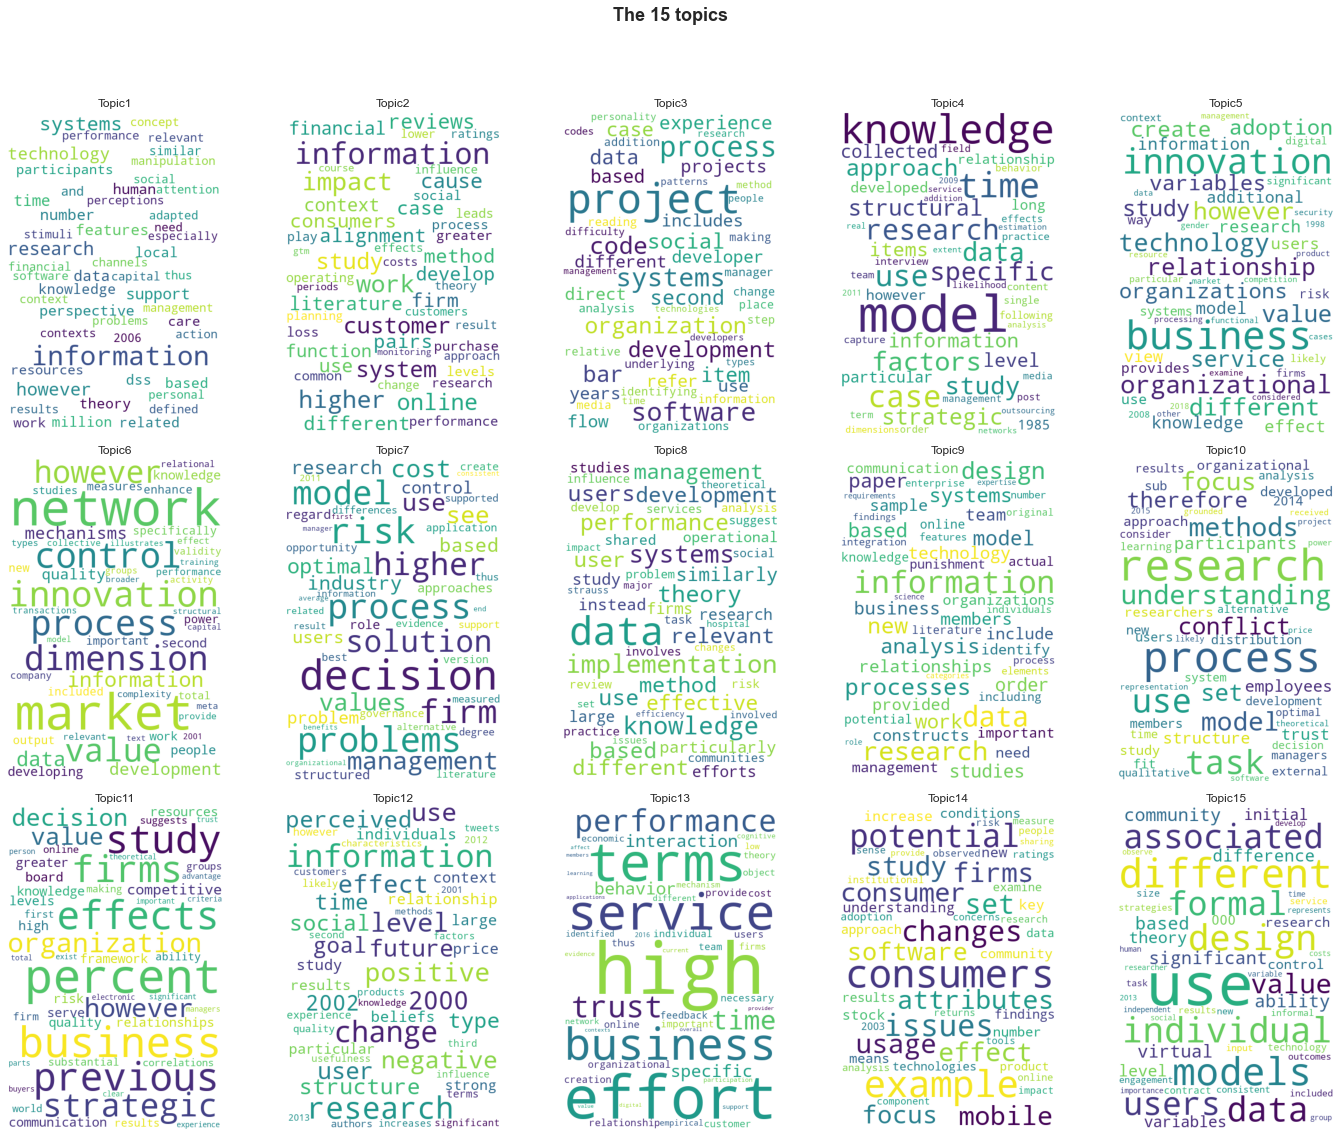

In [18]:
cloud = WordCloud(background_color='white',
                  prefer_horizontal=1,
                  height=600,
                  max_words=400,
                  collocations=True)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(3, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    plt.imshow(cloud.fit_words(dict(ldamodel.show_topic(i, 50))))
    plt.gca().set_title('Topic' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.suptitle("The 15 topics", 
             y=1.05,
             fontsize=18,
             fontweight='bold'
             )
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
ldamodel.show_topics()
#while there are some words that clearly go towards a label (e.g. "research","theory","effect","data")
#most of the words are applicable to all of the topics

#this suggests that LDA is not very applicable for this problem due to the independency of our target topics and the words
#rather this is clustering back into the articles than the labels; or a mix between label and article

[(14,
  '0.023*"use" + 0.011*"different" + 0.010*"models" + 0.008*"design" + 0.008*"individual" + 0.008*"data" + 0.007*"associated" + 0.007*"formal" + 0.007*"users" + 0.007*"value"'),
 (9,
  '0.022*"research" + 0.022*"process" + 0.012*"task" + 0.012*"use" + 0.011*"understanding" + 0.010*"methods" + 0.010*"model" + 0.009*"focus" + 0.008*"set" + 0.008*"conflict"'),
 (6,
  '0.016*"decision" + 0.011*"risk" + 0.011*"process" + 0.011*"problems" + 0.010*"model" + 0.009*"firm" + 0.009*"higher" + 0.008*"solution" + 0.008*"management" + 0.007*"cost"'),
 (7,
  '0.010*"data" + 0.010*"implementation" + 0.009*"systems" + 0.009*"knowledge" + 0.008*"theory" + 0.008*"performance" + 0.008*"based" + 0.008*"use" + 0.007*"users" + 0.007*"management"'),
 (4,
  '0.011*"business" + 0.010*"innovation" + 0.009*"organizational" + 0.009*"technology" + 0.008*"different" + 0.008*"however" + 0.008*"relationship" + 0.008*"value" + 0.007*"service" + 0.007*"study"'),
 (12,
  '0.014*"high" + 0.013*"effort" + 0.010*"term

In [20]:
#Idea1: because its hard to select the model manuelly -> lets loop over all combinations (its quite many)
#calculate the accuracy for each possibility and hope that the words are representative enough to use them to assign the labels -> does not really make sense because of 15! possibilities

#Idea2: Distribute topics depending on word occurences, then decide with heatmap

In [21]:
all_topics = ldamodel.get_document_topics(doc_term_matrix)
all_topics = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics.T.toarray()

In [22]:
#Get single best fitting topic
topics=ldamodel[doc_term_matrix]
topic_found = [np.argmax(doc) for doc in all_topics_numpy]
df_new["topics_lda"] = topic_found

## LDA with SKLearn

In [23]:
#Vectorize data
idf = TfidfVectorizer(max_df = 0.1) 

text_idf = idf.fit_transform(df_new.new_text).toarray()
lda_skl = LinearDiscriminantAnalysis()
lda_fit = lda_skl.fit(text_idf, list(df_new.accept)).transform(text_idf)

df_new["lda_x"] = lda_fit[:,0]
df_new["lda_y"] = lda_fit[:,1]
df_new["lda_z"] = lda_fit[:,2]

#evaluate variance per component
lda_skl.explained_variance_ratio_
#3 components only explain 45% of variance; this is lower than usual but due to the high amount of labels

array([0.24589547, 0.10561705, 0.10359585, 0.09863637, 0.08310849,
       0.06691404, 0.05570501, 0.05418502, 0.03968729, 0.0386241 ,
       0.03466552, 0.02660501, 0.02408825, 0.02267254])

In [105]:
map_col = {0:"b", 1:"g", 2:"k", 3:"r", 4:"y",5:"c", 6:"m", 7:"lime", 8:"orange", 9:"brown",
          10:"lightsalmon", 11:"lightblue", 12:"darkblue", 13:"purple",14:"grey"}
df_new["colours"] = df_new["topics_lda"].map(map_col)

<IPython.core.display.Javascript object>


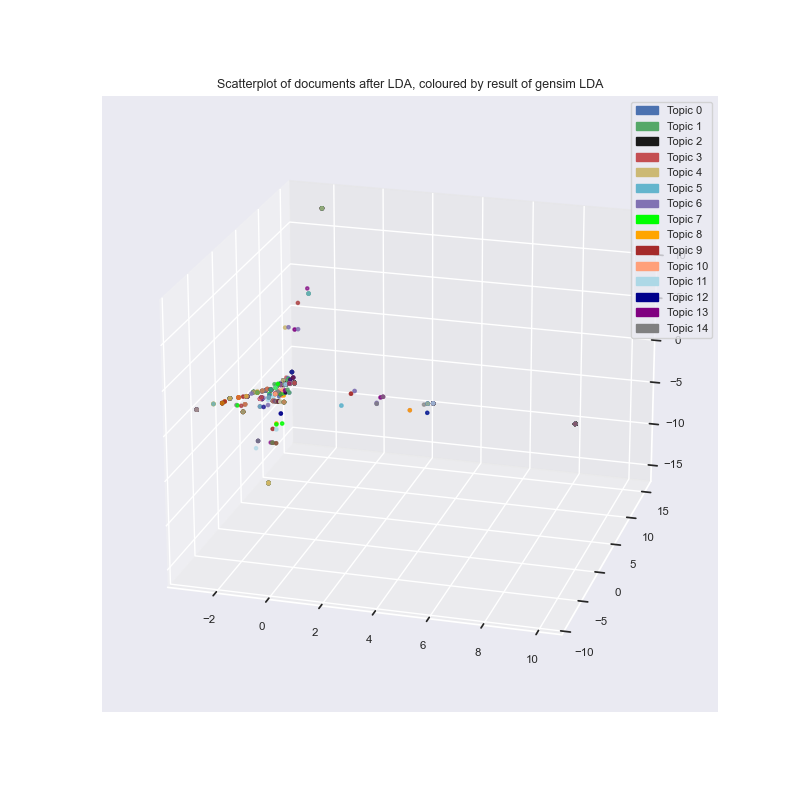

In [107]:
#for interactive 3D plot go to jupyter and run
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
#define axis

ax.scatter(df_new.lda_x,df_new.lda_y,df_new.lda_z, c = df_new["colours"], alpha = 0.4, s = 5)

#define handles with colour and title for legend
col_0 = mpatches.Patch(color='b', label='Topic 0')
col_1 = mpatches.Patch(color='g', label='Topic 1')
col_2 = mpatches.Patch(color='k', label='Topic 2')
col_3 = mpatches.Patch(color='r', label='Topic 3')
col_4 = mpatches.Patch(color='y', label='Topic 4')
col_5 = mpatches.Patch(color='c', label='Topic 5')
col_6 = mpatches.Patch(color='m', label='Topic 6')
col_7 = mpatches.Patch(color='lime', label='Topic 7')
col_8 = mpatches.Patch(color='orange', label='Topic 8')
col_9 = mpatches.Patch(color='brown', label='Topic 9')
col_10 = mpatches.Patch(color='lightsalmon', label='Topic 10')
col_11 = mpatches.Patch(color='lightblue', label='Topic 11')
col_12 = mpatches.Patch(color='darkblue', label='Topic 12')
col_13 = mpatches.Patch(color='purple', label='Topic 13')
col_14 = mpatches.Patch(color='grey', label='Topic 14')

handles=[col_0, col_1, col_2, col_3, col_4, col_5, col_6, col_7, col_8, col_9, col_10, col_11, col_12, col_13, col_14]
plt.legend(handles = handles, loc = "upper right", fontsize = 8)
plt.title("Scatterplot of documents after LDA, coloured by result of gensim LDA");
#there are some heavy outliers, but in general, the points are very scattered and there are no clear clusters visible

## Visualizing topics with only one label

<IPython.core.display.Javascript object>


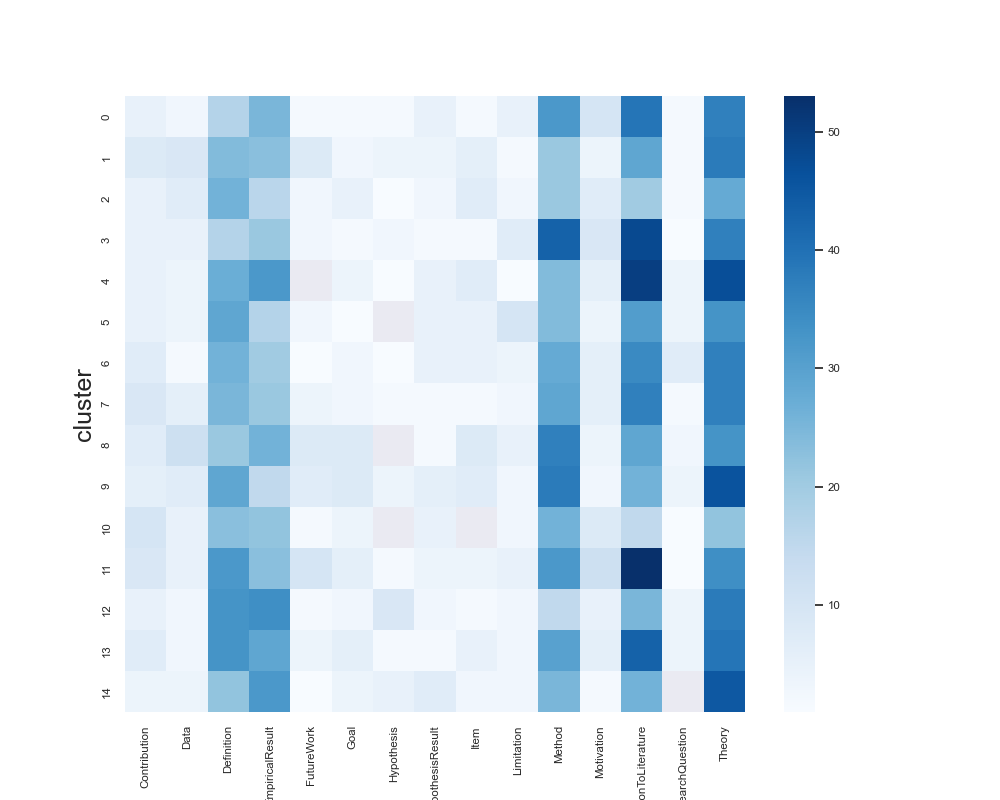

In [26]:
clusters = df_new.groupby(['topics_lda', 'accept']).size()
fig, ax1 = plt.subplots(figsize = (10, 8))
sns.heatmap(clusters.unstack(level = 'accept'), ax = ax1, cmap = "Blues")
ax1.set_xlabel('accept').set_size(18)
ax1.set_ylabel('cluster').set_size(18)
#many clusters refer to the Definition, EmpiricalResult, Method, RelationToLiterature and Theory
#logically, this highly correlates to the number of labels assigned

In [27]:
#lets compute relative frequencies instead
freq = df_new.groupby(['topics_lda', 'accept']).count().reset_index()
freq["rel_freq"] = 0
for index in freq.index:
    freq["rel_freq"].iloc[index] = freq.new_text.iloc[index] / list(df_new.accept).count(freq.accept.iloc[index])
freq = freq[["topics_lda", "accept", "rel_freq"]]
freq.set_index(["topics_lda", "accept"]).unstack(level = "accept", fill_value = 0)
#here is a view of the the relative frequencies as numbers

rel_freq                                                  \
accept     Contribution      Data Definition EmpiricalResult FutureWork   
topics_lda                                                                
0              0.051546  0.037975   0.044271        0.070225   0.034483   
1              0.082474  0.113924   0.062500        0.064607   0.137931   
2              0.051546  0.088608   0.067708        0.044944   0.051724   
3              0.051546  0.063291   0.044271        0.058989   0.051724   
4              0.051546  0.050633   0.070312        0.089888   0.000000   
5              0.051546  0.050633   0.075521        0.047753   0.051724   
6              0.072165  0.025316   0.067708        0.056180   0.017241   
7              0.092784  0.075949   0.065104        0.058989   0.068966   
8              0.072165  0.151899   0.054688        0.073034   0.137931   
9              0.061856  0.088608   0.075521        0.042135   0.120690   
10             0.103093  0.063291   0.059896        0.061798   0.034483   
11             0.092784  0.063291   0.083333        0.064607   0.172414   
12             0.051546  0.037975   0.085938        0.095506   0.034483   
13             0.072165  0.037975   0.085938        0.081461   0.068966   
14             0.041237  0.050633   0.057292        0.089888   0.017241   

                                                                       \
accept          Goal Hypothesis HypothesisResult      Item Limitation   
topics_lda                                                              
0           0.032258   0.055556         0.083333  0.030769   0.083333   
1           0.048387   0.111111         0.066667  0.092308   0.033333   
2           0.080645   0.027778         0.050000  0.107692   0.050000   
3           0.032258   0.083333         0.033333  0.030769   0.116667   
4           0.064516   0.027778         0.083333  0.107692   0.016667   
5           0.016129   0.000000         0.083333  0.076923   0.166667   
6           0.048387   0.027778         0.083333  0.076923   0.066667   
7           0.048387   0.055556         0.033333  0.030769   0.050000   
8           0.129032   0.000000         0.033333  0.123077   0.083333   
9           0.129032   0.111111         0.100000  0.107692   0.050000   
10          0.064516   0.000000         0.083333  0.000000   0.050000   
11          0.096774   0.055556         0.066667  0.061538   0.083333   
12          0.048387   0.250000         0.050000  0.030769   0.050000   
13          0.096774   0.055556         0.033333  0.076923   0.050000   
14          0.064516   0.138889         0.116667  0.046154   0.050000   

                                                                       \
accept        Method Motivation RelationToLiterature ResearchQuestion   
topics_lda                                                              
0           0.075294   0.108696             0.077075         0.048780   
1           0.049412   0.043478             0.057312         0.048780   
2           0.049412   0.076087             0.039526         0.048780   
3           0.101176   0.097826             0.094862         0.024390   
4           0.056471   0.065217             0.098814         0.097561   
5           0.056471   0.043478             0.061265         0.097561   
6           0.065882   0.065217             0.069170         0.170732   
7           0.068235   0.065217             0.073123         0.048780   
8           0.087059   0.043478             0.057312         0.073171   
9           0.089412   0.032609             0.051383         0.097561   
10          0.061176   0.086957             0.029644         0.024390   
11          0.075294   0.130435             0.104743         0.024390   
12          0.035294   0.054348             0.049407         0.097561   
13          0.070588   0.065217             0.084980         0.097561   
14          0.058824   0.021739             0.051383         0.000000   

                      
accept     

<IPython.core.display.Javascript object>


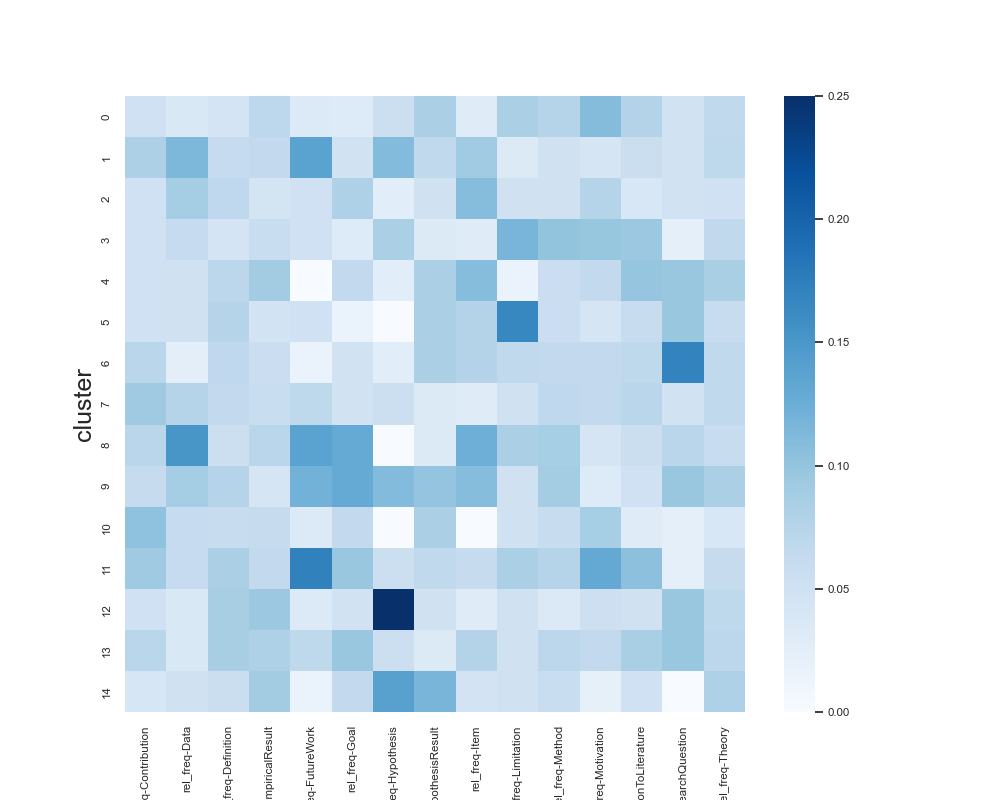

In [28]:
fig, ax1 = plt.subplots(figsize = (10, 8))
sns.heatmap(freq.set_index(["topics_lda", "accept"]).unstack(level = "accept", fill_value = 0), ax = ax1, cmap = "Blues")
ax1.set_xlabel('accept').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

#These results look more reliable. 
#However, several things are to be said about the output. First, because we exploded the dataframe, several rows (and their words) play into more than one category
#In result, we can also see likely combinations of labels:
    #0: ??? possibly Motivation
    #1: Future Work 
        #might possibly be Hypothesis as well, but I suspect its rather because of same articles than shared important words
    #2: ??? possibly Item
    #3: ??? possibly Limitation
    #4: ??? possibly Item
    #5: Limitation
    #6: Research Question
    #7: ???
    #8: Data, Future Work, Goal, Item
    #9: Future Work, Goal, Hypothesis, Hypothesis Result, Item ##what a mix!
    #10: ??? possibly Contribution
    #11: Future Work, Motivation
    #12: Hypothesis
    #13: ???
    #14: Hypothesis, Hypothesis Result
    
#Contribution, Definition, Empirical Result, Method, Relation to Literature, Theory are all not really linked to any topics
#4 of the 5 most common categories are not represented in topics
#This may hints at topics being random, while the document base for the other labels is too small to get representative results

## What threshold could we pick?

In [34]:
all_topics_numpy[0]
#clear

array([0.02222265, 0.02222262, 0.68888307, 0.02222265, 0.02222261,
       0.02222263, 0.0222226 , 0.02222267, 0.02222273, 0.02222261,
       0.02222261, 0.02222262, 0.02222262, 0.02222262, 0.02222265])

In [35]:
all_topics_numpy[2]
#clear

array([0.        , 0.        , 0.        , 0.        , 0.90666056,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [36]:
all_topics_numpy[25]
#tossup

array([0.39041102, 0.23520267, 0.32992923, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [37]:
all_topics_numpy[50]
#clear

array([0.01333461, 0.01333461, 0.58997434, 0.01333466, 0.01333461,
       0.01333461, 0.23667559, 0.01333461, 0.01333461, 0.01333461,
       0.01333461, 0.01333463, 0.01333462, 0.01333462, 0.01333461])

In [38]:
#Above you can see some curated examples, on first glance .3 seems like a decent threshold to assign a topic, given that some texts (like 25) achieve only barely higher scores at max
#However, there are also some cases, where all have the same value. picking the maximum will in that case be useles.
#Lets count how many labels we get per text based on different threshold
thresholds = np.arange(0.05, 1.0, 0.05)
for threshold in thresholds:
    thresh_res = []
    for arr in all_topics_numpy:
        thresh_res.append(np.count_nonzero(arr >= threshold))
    print(f""" on the threshold {round(threshold,3)}, {thresh_res.count(0)} out of {df_new.shape[0]} are null ({round(thresh_res.count(0)/df_new.shape[0]*100, 2)}%), on average {round(np.mean(thresh_res),3)} labels are given per text (original data: {avg_labels_per_text})""")
#threshold with this approach should be between 0.25 and 0.3
#possibly a more sophisticated algorithm would also be interesting, that also includes the distance between the most relevant topic and the other relevant topics
    #this idea is due to the fact that 49% of texts have one topic that must be clearly dominating with values over .85

 on the threshold 0.05, 0 out of 2872 are null (0.0%), on average 1.58 labels are given per text (original data: 1.258)
 on the threshold 0.1, 2 out of 2872 are null (0.07%), on average 1.549 labels are given per text (original data: 1.258)
 on the threshold 0.15, 2 out of 2872 are null (0.07%), on average 1.494 labels are given per text (original data: 1.258)
 on the threshold 0.2, 2 out of 2872 are null (0.07%), on average 1.403 labels are given per text (original data: 1.258)
 on the threshold 0.25, 2 out of 2872 are null (0.07%), on average 1.308 labels are given per text (original data: 1.258)
 on the threshold 0.3, 13 out of 2872 are null (0.45%), on average 1.212 labels are given per text (original data: 1.258)
 on the threshold 0.35, 53 out of 2872 are null (1.85%), on average 1.107 labels are given per text (original data: 1.258)
 on the threshold 0.4, 148 out of 2872 are null (5.15%), on average 1.01 labels are given per text (original data: 1.258)
 on the threshold 0.45, 242

## LDA Results

- The results shown above look unpromising
- Although there are still open ideas we decided not to follow through with LDA due to extensive time limitations
- Open ideas are: getting most important words instead of most common words, utilizing semantic embeddings
- Defining the right threshold to accept multi labels
- Defining possibly are more sophisticated multilabel algorithm that takes difference in score into account 

    (e.g., if 0.65 & 0.45, possibly both should be labelled although the threshold is 0.5)